# 📝 MNIST Dataset: EDA & ViT Patching Exploration 🖼️➡️🧩

**🎯 Goal:** Perform Exploratory Data Analysis (EDA) on the standard MNIST dataset and implement the core patching + embedding mechanism for a Vision Transformer (ViT).

**🚀 This Notebook Covers:**
1.  ✅ Setup & Imports
2.  💾 Loading MNIST Dataset
3.  👀 Visualizing Sample Digits
4.  ✂️ Implementing Image-to-Patch Function
5.  🎨 Visualizing Patches
6.  📊 Implementing Linear Patch Embedding

## 1. Setup and Imports 🛠️🐍

In [1]:
import os
import sys
import re
import json
from pathlib import Path
from collections import Counter
import random

In [2]:
# Essential ML/Data libraries
import torch
import torch.nn as nn
import torch.nn.functional as F # Often useful
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Progress Bar
from tqdm.notebook import tqdm # Use notebook version for better display


In [6]:
# --- Add project root to sys.path for imports ---
# Assuming the notebook is run from the project root directory
project_root = Path(os.getcwd()).parent
src_path = project_root / 'src'
if str(project_root) not in sys.path:
    print(f"📂 Adding project root to sys.path: {project_root}")
    sys.path.insert(0, str(project_root))

# Import custom Vocabulary class and logger (Optional - if needed later, otherwise remove)
try:
    from utils import logger
except ImportError as e:
    print(f"⚠️ Error importing project logger: {e}")
    print("   Ensure you are running this notebook from the project root directory.")
    # Fallback logger if utils fails
    import logging
    logger = logging.getLogger("EDA_Notebook")
    logging.basicConfig(level=logging.INFO)
    logger.info("Using basic fallback logger.")

print("\n✅ Setup Complete.")

📂 Adding project root to sys.path: /Users/Oks_WORKSPACE/Desktop/DEV/W3_project/mlx-w3-mnist-transformer
⚙️  Configuring Backprop Bunch logging...
  Logger 'Backprop Bunch' level set to: INFO
  Clearing existing handlers...
  ✅ Console handler added.
  ✅ File handler added: logs/mnist_transformer.log
2025-04-28 14:46:18 | Backprop Bunch | INFO     | [logging.py:65] | 🎉 Logging system initialized!


INFO:Backprop Bunch:🎉 Logging system initialized!



✅ Setup Complete.


## 2. Load MNIST Dataset 💾🔢

We'll use `torchvision` to easily download and load the MNIST dataset. We'll apply standard normalization.

In [7]:
# Define basic transforms
# 1. Convert image to PyTorch Tensor
# 2. Normalize pixel values using mean and std dev calculated across MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # MNIST specific mean/std
])

# Define data path (usually relative to project root)
data_path = project_root / 'data'

# Load MNIST dataset
try:
    logger.info(f"💾 Loading MNIST dataset (will download to '{data_path}' if needed)...")
    train_dataset = torchvision.datasets.MNIST(root=data_path, train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root=data_path, train=False, download=True, transform=transform)
    logger.info(f"✅ MNIST loaded. Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
except Exception as e:
    logger.error(f"❌ Failed to load MNIST: {e}", exc_info=True)
    train_dataset, test_dataset = None, None

# Create data loaders (useful for grabbing batches easily)
if train_dataset and test_dataset:
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    logger.info("🚀 DataLoaders created.")
else:
    train_loader, test_loader = None, None
    logger.warning("Could not create DataLoaders as dataset failed to load.")

2025-04-28 14:47:49 | Backprop Bunch | INFO     | [562368551.py:14] | 💾 Loading MNIST dataset (will download to '/Users/Oks_WORKSPACE/Desktop/DEV/W3_project/mlx-w3-mnist-transformer/data' if needed)...


INFO:Backprop Bunch:💾 Loading MNIST dataset (will download to '/Users/Oks_WORKSPACE/Desktop/DEV/W3_project/mlx-w3-mnist-transformer/data' if needed)...
100%|██████████| 9.91M/9.91M [00:01<00:00, 7.24MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 368kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.67MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 261kB/s]

2025-04-28 14:47:55 | Backprop Bunch | INFO     | [562368551.py:17] | ✅ MNIST loaded. Train size: 60000, Test size: 10000



INFO:Backprop Bunch:✅ MNIST loaded. Train size: 60000, Test size: 10000


2025-04-28 14:47:55 | Backprop Bunch | INFO     | [562368551.py:26] | 🚀 DataLoaders created.


INFO:Backprop Bunch:🚀 DataLoaders created.


## 3. Visualize Sample Digits 👀

In [8]:
# Helper function to display images
def imshow(img_tensor, title=''):
    # Reverse the normalization for display purposes
    mean = torch.tensor([0.1307])
    std = torch.tensor([0.3081])
    img_tensor = img_tensor * std[:, None, None] + mean[:, None, None]
    
    # Clamp values to [0, 1] range
    img_tensor = torch.clamp(img_tensor, 0, 1)
    
    # Convert to numpy for plotting
    npimg = img_tensor.numpy()
    
    # Plot
    plt.imshow(np.squeeze(npimg), cmap='gray') # Use np.squeeze for grayscale
    plt.title(title)
    plt.axis('off') # Hide axes for cleaner look


In [ ]:
# Get a batch of training images
sample_image = None # Initialize in case loader failed
sample_label = None

2025-04-28 14:48:26 | Backprop Bunch | INFO     | [1436535450.py:6] | 👀 Displaying sample MNIST digits:


INFO:Backprop Bunch:👀 Displaying sample MNIST digits:


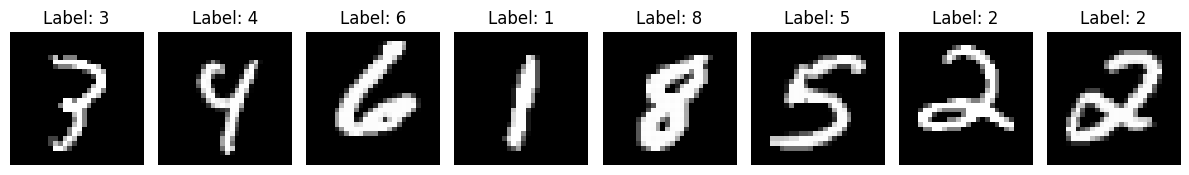

2025-04-28 14:48:26 | Backprop Bunch | INFO     | [1436535450.py:21] | 💾 Selected one image (Label: 3) for patching demonstration.


INFO:Backprop Bunch:💾 Selected one image (Label: 3) for patching demonstration.


In [10]:
if train_loader:
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    # Show images
    logger.info("👀 Displaying sample MNIST digits:")
    num_images_to_show = 8
    plt.figure(figsize=(12, 4)) # Adjust figure size 
    for i in range(num_images_to_show):
        if i >= len(images):
             break # Handle smaller batches
        plt.subplot(1, num_images_to_show, i+1)
        imshow(images[i], title=f"Label: {labels[i].item()}")
    plt.tight_layout()
    plt.show()

    # Keep one image for the patching example
    if len(images) > 0:
        sample_image = images[0]
        sample_label = labels[0]
        logger.info(f"💾 Selected one image (Label: {sample_label.item()}) for patching demonstration.")
else:
    logger.warning("🤷 Train loader not available, cannot visualize samples or select one for patching.")


## 4. Patching Implementation ✂️🧩

Now, the core idea of ViT: splitting the image into non-overlapping patches. For a 28x28 MNIST image and a 7x7 patch size, we expect (28/7) x (28/7) = 4x4 = 16 patches. Each patch will be 7x7 pixels (and 1 channel for grayscale).

In [11]:
def image_to_patches(image_tensor: torch.Tensor, patch_size: int = 7) -> torch.Tensor:
    """
    Splits a single image tensor (C, H, W) into a sequence of flattened patches.
    Uses torch.Tensor.unfold for efficient patching.

    Args:
        image_tensor (torch.Tensor): Input image tensor (e.g., 1x28x28 for MNIST).
        patch_size (int): The height and width of each square patch.

    Returns:
        torch.Tensor: Tensor of flattened patches (NumPatches, PatchDim).
                    Returns empty tensor if input is invalid.
    """
    # Basic validation
    if not isinstance(image_tensor, torch.Tensor) or image_tensor.ndim != 3:
        logger.error(f"❌ Invalid input: Expected a 3D tensor (C, H, W), got {image_tensor.shape if isinstance(image_tensor, torch.Tensor) else type(image_tensor)}")
        return torch.empty(0)
        
    c, h, w = image_tensor.shape
    if h % patch_size != 0 or w % patch_size != 0:
        logger.error(f"❌ Image dimensions ({h}x{w}) must be divisible by patch_size ({patch_size}).")
        return torch.empty(0)

    num_patches_h = h // patch_size
    num_patches_w = w // patch_size
    num_patches = num_patches_h * num_patches_w
    patch_dim = c * patch_size * patch_size

    logger.debug(f"Input image shape: {image_tensor.shape}")
    logger.debug(f"Patch size: {patch_size}x{patch_size}")
    logger.debug(f"Calculated num_patches: {num_patches} ({num_patches_h}x{num_patches_w})")
    logger.debug(f"Calculated patch_dim (flattened): {patch_dim}")

    try:
        # Use unfold to extract patches. unfold(dimension, size, step)
        # Unfold height, then width
        patches = image_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        # Current shape: (C, NumPatchesH, NumPatchesW, PatchH, PatchW)
        logger.debug(f"Shape after unfold: {patches.shape}")

        # Permute and reshape to get (NumPatches, C, PatchH, PatchW)
        patches = patches.permute(1, 2, 0, 3, 4).contiguous()
        # Shape: (NumPatchesH, NumPatchesW, C, PatchH, PatchW)
        logger.debug(f"Shape after permute: {patches.shape}")
        
        # Reshape to (NumPatches, PatchDim) by flattening C, PatchH, PatchW
        patches = patches.view(num_patches, patch_dim)
        # Shape: (NumPatches, C * PatchH * PatchW)

        logger.debug(f"✅ Output patches shape: {patches.shape}") # Should be (16, 49) for MNIST 7x7
        return patches
    except Exception as e:
        logger.error(f"❌ Error during patching: {e}", exc_info=True)
        return torch.empty(0)


In [12]:
# --- Test the function --- 
patches_tensor = None # Initialize
if sample_image is not None:
    logger.info("⚙️ Testing image_to_patches function...")
    patches_tensor = image_to_patches(sample_image, patch_size=7)
    if patches_tensor.nelement() > 0: # Check if tensor is not empty
        logger.info(f"✅ Successfully created patches tensor with shape: {patches_tensor.shape}")
    else:
        logger.warning("⚠️ Patch tensor is empty, likely due to previous errors.")
else:
     logger.warning("🤷 No sample image available to test patching.")

2025-04-28 14:48:44 | Backprop Bunch | INFO     | [2428247436.py:4] | ⚙️ Testing image_to_patches function...


INFO:Backprop Bunch:⚙️ Testing image_to_patches function...


2025-04-28 14:48:44 | Backprop Bunch | INFO     | [2428247436.py:7] | ✅ Successfully created patches tensor with shape: torch.Size([16, 49])


INFO:Backprop Bunch:✅ Successfully created patches tensor with shape: torch.Size([16, 49])


## 5. Visualize Patches 🎨

2025-04-28 14:48:49 | Backprop Bunch | INFO     | [3373689613.py:2] | 🎨 Visualizing the 16 generated patches (reshaped):


INFO:Backprop Bunch:🎨 Visualizing the 16 generated patches (reshaped):


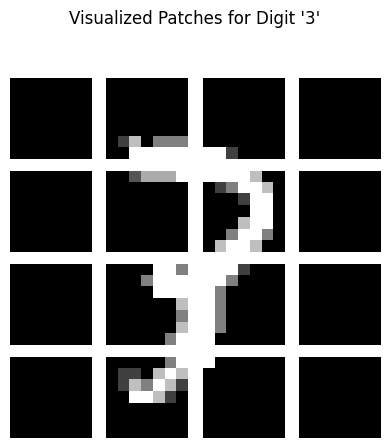

In [13]:
if patches_tensor is not None and patches_tensor.nelement() > 0:
    logger.info(f"🎨 Visualizing the {patches_tensor.shape[0]} generated patches (reshaped):")
    try:
        num_patches = patches_tensor.shape[0]
        patch_dim = patches_tensor.shape[1]
        # Assuming square patches and single channel (MNIST)
        patch_size = int(patch_dim**0.5) 
        num_patches_side = int(num_patches**0.5) 
        
        if num_patches_side * num_patches_side != num_patches or patch_size * patch_size != patch_dim:
             raise ValueError("Cannot determine square layout for patches.")

        plt.figure(figsize=(num_patches_side, num_patches_side + 0.5)) # Adjust size
        plt.suptitle(f"Visualized Patches for Digit '{sample_label.item()}'", y=1.02)
        for i, patch_flat in enumerate(patches_tensor):
            plt.subplot(num_patches_side, num_patches_side, i + 1)
            # Reshape flattened patch back to image format (1, P, P)
            patch_img = patch_flat.view(1, patch_size, patch_size)
            
            # Display the patch (no need to unnormalize, as we took it *before* imshow unnormalized)
            plt.imshow(patch_img.squeeze().numpy(), cmap='gray')
            plt.axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout
        plt.show()
    except Exception as e:
        logger.error(f"❌ Failed to visualize patches: {e}")
else:
    logger.warning("🤷 Patch tensor not available or empty for visualization.")

## 6. Linear Patch Embedding 📊✨

Now, we project each flattened patch vector (size 7x7 = 49) into a higher-dimensional embedding space (e.g., 64 dimensions) using a simple Linear layer. This is the first step in preparing the patches for the Transformer Encoder.

In [14]:
if patches_tensor is not None and patches_tensor.nelement() > 0:
    patch_dim = patches_tensor.shape[1] # Should be 49
    embedding_dim = 64 # Example embedding dim from our ViT plan
    num_patches = patches_tensor.shape[0] # Should be 16
    
    logger.info(f"⚙️ Creating Linear layer to embed patches: {patch_dim} -> {embedding_dim} dimensions.")

    # Create the embedding layer
    patch_embed_layer = nn.Linear(patch_dim, embedding_dim)
    logger.info(f"Embedding Layer: {patch_embed_layer}")

    # Embed the patches. Input shape for Linear: (Batch, *, InFeatures)
    # Our patches_tensor is (NumPatches, PatchDim). Add a batch dim [1, N, P_dim].
    try:
        patch_embeddings = patch_embed_layer(patches_tensor.unsqueeze(0)) # Add batch dim
        logger.info(f"✅ Shape after embedding: {patch_embeddings.shape}") # Should be (1, 16, 64)

        print("\n🔬 Sample embedding vector (first patch, first 10 values):")
        print(patch_embeddings[0, 0, :10].detach().numpy()) # Print embedding of the first patch
    except Exception as e:
        logger.error(f"❌ Error during embedding: {e}", exc_info=True)
        
else:
    logger.warning("🤷 Patch tensor not available or empty for embedding test.")

2025-04-28 14:48:57 | Backprop Bunch | INFO     | [957879427.py:6] | ⚙️ Creating Linear layer to embed patches: 49 -> 64 dimensions.


INFO:Backprop Bunch:⚙️ Creating Linear layer to embed patches: 49 -> 64 dimensions.


2025-04-28 14:48:57 | Backprop Bunch | INFO     | [957879427.py:10] | Embedding Layer: Linear(in_features=49, out_features=64, bias=True)


INFO:Backprop Bunch:Embedding Layer: Linear(in_features=49, out_features=64, bias=True)


2025-04-28 14:48:57 | Backprop Bunch | INFO     | [957879427.py:16] | ✅ Shape after embedding: torch.Size([1, 16, 64])


INFO:Backprop Bunch:✅ Shape after embedding: torch.Size([1, 16, 64])



🔬 Sample embedding vector (first patch, first 10 values):
[ 0.24040817  0.10694408  0.09202305  0.25400162 -0.07495159  0.2716779
 -0.19218512 -0.50649714 -0.03054794  0.0562887 ]


## 7. Conclusion & Next Steps ✅🚀

We have successfully:
*   Loaded the MNIST dataset.
*   Visualized sample digits.
*   Implemented a function to split images into patches.
*   Visualized the resulting patches.
*   Implemented a linear layer to create patch embeddings.

This notebook confirms our understanding of the initial data processing steps for ViT. The next steps involve building the full ViT architecture (`PatchEmbedding` class, Positional Embeddings, Transformer Encoder blocks, MLP Head) in the `src/` directory.